### why wasserstein
- https://jamesmccaffrey.wordpress.com/2021/08/23/comparing-wasserstein-distance-with-kullback-leibler-distance/

*We haver common support of all points, so in theory KL and JS can be used.

### this impl.
- https://github.com/pkomiske/Wasserstein/
- https://github.com/pkomiske/Wasserstein/blob/master/demos/Wasserstein%20Demo.ipynb
- https://pypi.org/project/Wasserstein/
- https://pkomiske.github.io/Wasserstein/


### Potentiall More scalable version:
- https://github.com/lrcfmd/ElM2D
- https://github.com/sparks-baird/chem_wasserstein
- https://pypi.org/project/chem_wasserstein/
- https://github.com/KrishnaswamyLab/DiffusionEMD

### pytorch appprox:
- https://dfdazac.github.io/sinkhorn.html (THIS!)
- https://github.com/dfdazac/wassdistance
- https://github.com/gpeyre/SinkhornAutoDiff
- https://www.kernel-operations.io/geomloss/index.html
- https://www.kernel-operations.io/geomloss/api/pytorch-api.html (potentially interesting loss!!!)
- https://github.com/dfdazac/wassdistance/blob/master/layers.py (mini batch implimentation)

more pytorch sinkhorn:
- https://gist.github.com/wohlert/8589045ab544082560cc5f8915cc90bd
- https://gist.github.com/noskill/c32f2e6148e14f2f9a2945b03bab42ac

In [1]:
import numpy as np
import torch
from layers import SinkhornDistance
import wasserstein
import matplotlib.pyplot as plt


# Wasserstein
- https://github.com/pkomiske/Wasserstein/
- https://github.com/pkomiske/Wasserstein/blob/master/demos/Wasserstein%20Demo.ipynb

In [2]:

# create an EMD object with the default parameters
emd = wasserstein.EMD(n_iter_max = 200000)
print(emd)

EMD
  ArrayEvent<8-byte float, variable particle dimension>
    norm - false
    external_dists - false

  EuclideanArrayDistance
    R - 1
    beta - 1

  NetworkSimplex
    n_iter_max - 200000
    epsilon_large - 2.22045e-13
    epsilon_small - 2.22045e-16



In [3]:

# get some points in a euclidean space
M = 25 # go higer then and lap top can't allocate enough ram. No issue on computerome
coords0, coords1 = np.random.rand(2, M, 2) # would be spatial coordinates of dist0 and dist1
weights0, weights1 = np.random.rand(2, M) # would be the true/estimated values for each point.

# run EMD computation
emd_val = emd(weights0, coords0, weights1, coords1)
print('EMD value:', emd_val)

EMD value: 4.3745753569063135


In [4]:
def show_wasserstein(emdm, weights0, coords0, weights1, coords1):

    flows = emd.flows()

    # plot the events
    zf = 100
    plt.scatter(coords0[:,0], coords0[:,1], s=zf*weights0, lw=0, color='red')
    plt.scatter(coords1[:,0], coords1[:,1], s=zf*weights1, lw=0, color='blue')

    # plot flows
    cmap = plt.get_cmap('Greys')
    fmax = flows.max()
    for i in range(len(weights0)):
        for j in range(len(weights1)):
            f = flows[i,j]
            if f > 0.:
                plt.plot([coords0[i,0], coords1[j,0]], [coords0[i,1], coords1[j,1]],
                        lw=1.5, color=cmap(f/fmax), zorder=0)

    plt.axis('off')
    plt.show()


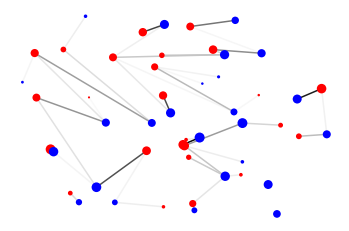

In [5]:
show_wasserstein(emd, weights0, coords0, weights1, coords1)

# Sinkhorn
- https://dfdazac.github.io/sinkhorn.html
- https://github.com/dfdazac/wassdistance

In [6]:
# M = 25 # go higer 20-30.000 and lap top can't allocate enough ram. No issue on computerome
# coords0, coords1 = np.random.rand(2, M, 2) # would be spatial coordinates of dist0 and dist1
# weights0, weights1 = np.random.rand(2, M) # would be the true/estimated values for each point.

# I hope this column stack is a valid solutino

a = np.column_stack([coords0, weights0])
b = np.column_stack([coords1, weights1])

x = torch.tensor(a, dtype=torch.float)
y = torch.tensor(b, dtype=torch.float)

sinkhorn = SinkhornDistance(eps=0.01, max_iter=1000, reduction=None)
dist, P, C = sinkhorn(x, y)
print("Sinkhorn distance: {:.3f}".format(dist.item()))

Sinkhorn distance: 0.056


In [7]:

def show_sinkhorn(a, b, P):    
    norm_P = P/P.max()
    for i in range(a.shape[0]):
        for j in range(b.shape[0]):
            plt.arrow(a[i, 0], a[i, 1], b[j, 0]-a[i, 0], b[j, 1]-a[i, 1],
                     alpha=norm_P[i,j].item())
    plt.scatter(a[:, 0], a[:, 1], s=a[:,2]*100, color='red')
    plt.scatter(b[:, 0], b[:, 1], s=b[:,2]*100, color='blue')
    plt.axis('off')

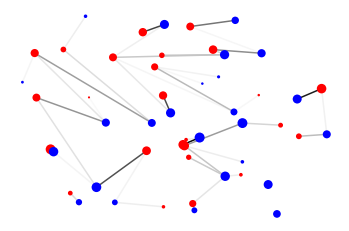

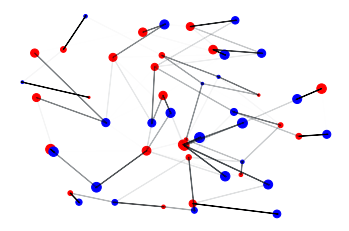

In [8]:
show_wasserstein(emd, weights0, coords0, weights1, coords1)
show_sinkhorn(a, b, P)

In [9]:
# plt.imshow(C)
# plt.title('Distance matrix')
# plt.colorbar();
# plt.show()

# plt.imshow(P)
# plt.title('Coupling matrix');
# plt.show()

# sinkhorn (GeomLoss)
- https://www.kernel-operations.io/geomloss/index.html

In [10]:
import geomloss

In [37]:
loss = geomloss.SamplesLoss(loss='sinkhorn', p = 1, blur= 0.001)
loss(x,y)

tensor(0.2443)